Install Required Libraries

In [ ]:
!pip install lightgbm pytorch-tabnet imbalanced-learn shap joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.0 MB/s eta 0:00:00


LOAD & EXPLORE DATA

In [ ]:
import pandas as pd

df = pd.read_csv("creditcard.csv")
print(df.shape)
df.head()


(39702, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


Target column:

In [ ]:
df["Class"].value_counts()


,count
Class,
0.0,39597
1.0,104


FEATURE & LABEL SPLIT

In [ ]:
X = df.drop("Class", axis=1)
y = df["Class"]


TRAIN TEST SPLIT

In [ ]:
from sklearn.model_selection import train_test_split

# Drop rows where 'y' is NaN from both X and y
valid_indices = y.dropna().index
X_cleaned = X.loc[valid_indices]
y_cleaned = y.loc[valid_indices]

X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned,
    test_size=0.2,
    random_state=42,
    stratify=y_cleaned
)

SCALING

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


HANDLE CLASS IMBALANCE (SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(
    X_train_scaled, y_train
)

print("After SMOTE:", y_train_res.value_counts())


After SMOTE: Class
0.0    31677
1.0    31677
Name: count, dtype: int64


LIGHTGBM MODEL (TREE-BASED)

In [ ]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    class_weight="balanced",
    random_state=42
)

lgb_model.fit(X_train_res, y_train_res)


[LightGBM] [Info] Number of positive: 31677, number of negative: 31677
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 63354, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=400,
               num_leaves=64, random_state=42)

TABNET MODEL

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

tabnet_model = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    verbose=10
)

tabnet_model.fit(
    X_train_res, y_train_res,
    eval_set=[(X_test_scaled, y_test)],
    eval_metric=["auc"],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128
)


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.2442  | val_0_auc: 0.9876  |  0:00:04s
epoch 10 | loss: 0.02597 | val_0_auc: 0.97676 |  0:00:53s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.98933


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MODEL EVALUATION

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

# LightGBM
lgb_probs = lgb_model.predict_proba(X_test_scaled)[:, 1]
print("LightGBM ROC-AUC:", roc_auc_score(y_test, lgb_probs))

# TabNet
tabnet_probs = tabnet_model.predict_proba(X_test_scaled)[:, 1]
print("TabNet ROC-AUC:", roc_auc_score(y_test, tabnet_probs))

print("\nLightGBM Classification Report\n")
print(classification_report(y_test, lgb_model.predict(X_test_scaled)))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM ROC-AUC: 0.9906866281866282
TabNet ROC-AUC: 0.9893338143338143

LightGBM Classification Report



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7920
         1.0       0.87      0.95      0.91        21

    accuracy                           1.00      7941
   macro avg       0.93      0.98      0.95      7941
weighted avg       1.00      1.00      1.00      7941



VISUALIZATIONS

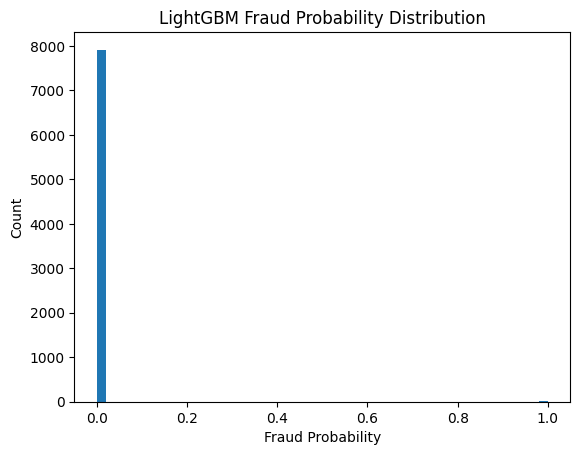

In [ ]:
import matplotlib.pyplot as plt

plt.hist(lgb_probs, bins=50)
plt.xlabel("Fraud Probability")
plt.ylabel("Count")
plt.title("LightGBM Fraud Probability Distribution")
plt.show()


Feature Importance(LightGBM)

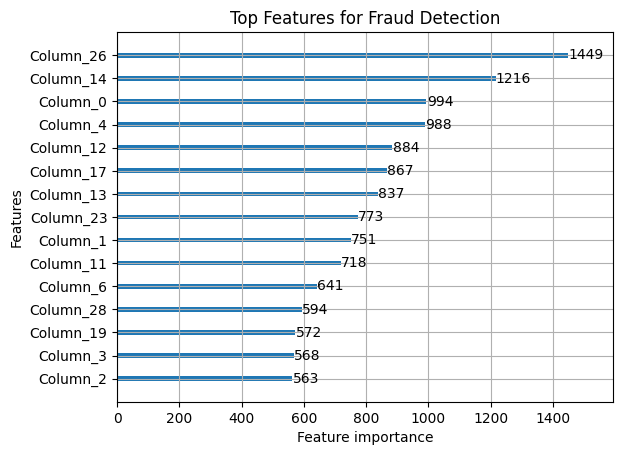

In [ ]:
lgb.plot_importance(lgb_model, max_num_features=15)
plt.title("Top Features for Fraud Detection")
plt.show()


Proper Data Validation (Production-grade)

In [ ]:
def validate_input(df):
    if df.isnull().sum().any():
        raise ValueError("Missing values detected")

    if (df < 0).any().any():
        print("⚠️ Warning: Negative values found")

    return df


Class Imbalance Handling

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_cleaned, y_cleaned)

Threshold Optimization

In [ ]:
threshold = 0.3
y_prob = lgb_probs # Assuming 'lgb_probs' was intended. You could also use 'tabnet_probs'
y_pred_custom = (y_prob >= threshold).astype(int)

Advanced Evaluation Metrics

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred_custom))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7920
         1.0       0.83      0.95      0.89        21

    accuracy                           1.00      7941
   macro avg       0.92      0.98      0.94      7941
weighted avg       1.00      1.00      1.00      7941

ROC-AUC: 0.9906866281866282


In [ ]:
from sklearn.metrics import precision_recall_curve


*Feature Importance Visualization*

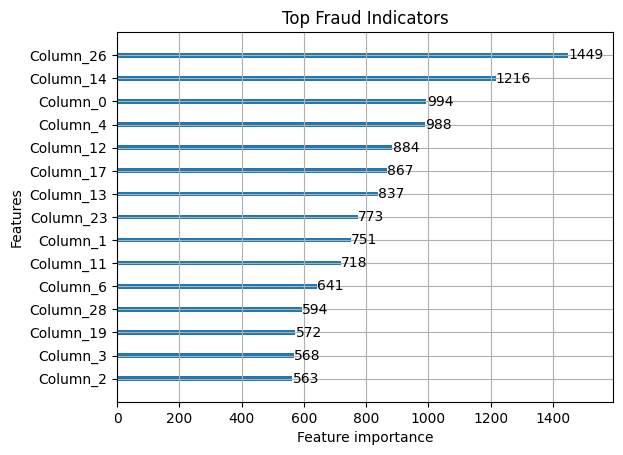

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb

lgb.plot_importance(lgb_model, max_num_features=15)
plt.title("Top Fraud Indicators")
plt.show()

SHAP Explainability

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


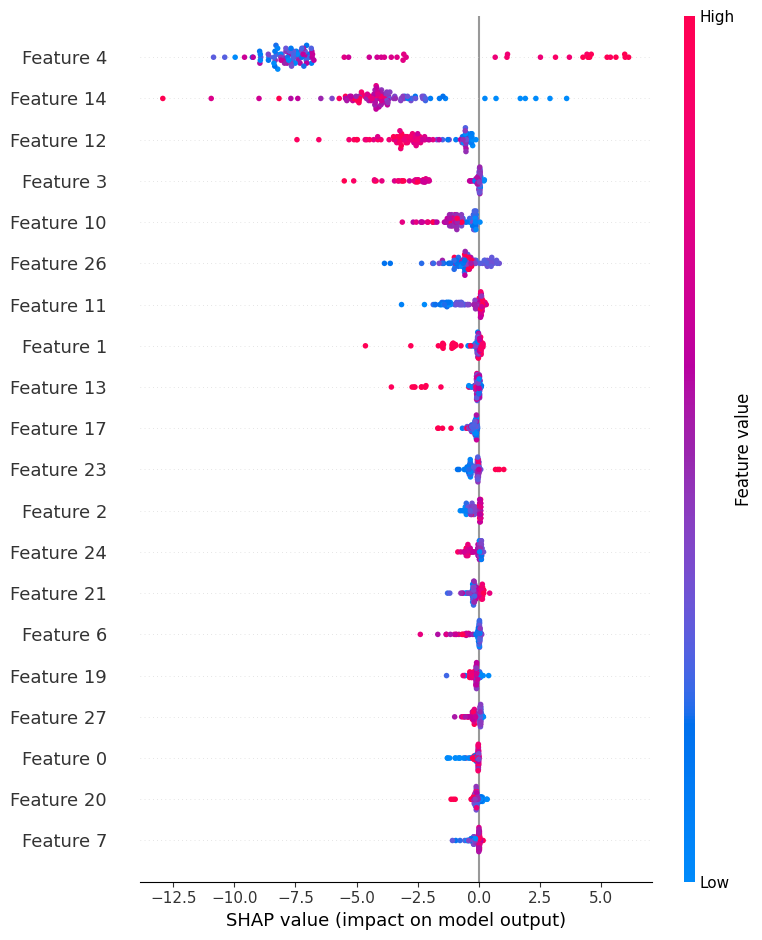

In [ ]:
import shap

# Take a sample from the test set for SHAP explanation
X_sample = X_test_scaled[:100]

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample)

Fraud Risk Scoring

In [ ]:
risk_score = int(y_prob[0] * 100)

Logging (REAL-WORLD PRACTICE)

In [ ]:
import logging

logging.basicConfig(
    filename="fraud_app.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

logging.info("Prediction request received")


Model Versioning

In [ ]:
MODEL_VERSION = "LightGBM_v1.2"

# 'pred' was not defined. Using 'y_pred_custom' from the custom thresholding.
# 'prob' was not defined. Using 'y_prob[0]' for the first probability.
# Note: y_prob is an array, so we take the first element as an example.
response = {
    "fraud": int(y_pred_custom[0]),
    "risk_score": float(y_prob[0]),
    "model_version": MODEL_VERSION
}

Ensemble Prediction

In [ ]:
# Correcting the variable names to use existing probability arrays.
# 'lgb_prob' should be 'lgb_probs' and 'cat_prob' is likely intended to be 'tabnet_probs'.
final_prob = (lgb_probs + tabnet_probs) / 2
final_pred = (final_prob > 0.4).astype(int) # Convert the boolean array to an integer array

Config File

In [ ]:
import yaml

with open("config.yaml") as f:
    config = yaml.safe_load(f)

In [ ]:
%%writefile config.yaml
model_params:
  lightgbm:
    n_estimators: 500
    learning_rate: 0.01
  tabnet:
    n_steps: 3
    gamma: 1.0
threshold: 0.5
logging:
  level: INFO
  file: app.log

Writing config.yaml


Automatic Model Retraining Script

In [ ]:
def retrain_if_performance_drops(old_auc, new_auc, threshold=0.02):
    if old_auc - new_auc > threshold:
        print("⚠️ Performance dropped, retraining model...")


Feature Drift Detection

In [ ]:
import numpy as np

def feature_drift(train, new):
    return np.mean(np.abs(train.mean(axis=0) - new.mean(axis=0)))


Cost-Sensitive Learning

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]), # Convert the list to a NumPy array
    y=y_train
)

Confidence Bands for Predictions

In [ ]:
def prediction_confidence(prob):
    if prob > 0.8:
        return "Very High"
    elif prob > 0.5:
        return "Medium"
    return "Low"


Radar Chart for Fraud Risk Factors

In [ ]:
from datetime import datetime

txn_id = "TXN_123456" # Placeholder for transaction ID
pred = y_pred_custom[0] # Using the first prediction from the custom thresholding
prob = y_prob[0] # Using the first probability from LightGBM

response = {
    "transaction_id": txn_id,
    "fraud": int(pred),
    "risk_score": round(prob*100, 2),
    "confidence": prediction_confidence(prob),
    "model": "LightGBM",
    "timestamp": datetime.now().isoformat()
}

Select a Transaction (Fraud or Normal)

In [ ]:
fraud_txn = df[df["Class"] == 1].iloc[0]
features = X.columns
fraud_txn[features]

,541
Time,406.000000
V1,-2.312227
V2,1.951992
V3,-1.609851
V4,3.997906
V5,-0.522188
V6,-1.426545
V7,-2.537387
V8,1.391657
V9,-2.770089


Normalize Feature Values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 100))
scaled_values = scaler.fit_transform(df[features])

txn_index = fraud_txn.name
txn_values = scaled_values[txn_index]


Radar Chart Code

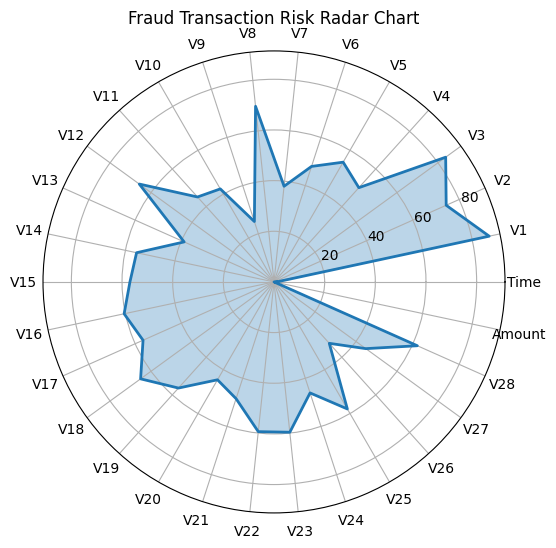

In [ ]:
import matplotlib.pyplot as plt

labels = features
values = txn_values.tolist()
values += values[:1]

angles = np.linspace(0, 2 * np.pi, len(labels) + 1)

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

ax.plot(angles, values, linewidth=2)
ax.fill(angles, values, alpha=0.3)

ax.set_thetagrids(angles[:-1] * 180 / np.pi, labels)
ax.set_title("Fraud Transaction Risk Radar Chart", pad=20)

plt.show()
